# Load Packages

In [1]:
import pandas as pd

pd.options.display.float_format = '{:,.4f}'.format

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error, explained_variance_score

from srcs.utils import load_data, print_scores, get_scores, calculate_metrics
import time
import tracemalloc
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# ignore warnings
import warnings

warnings.filterwarnings('ignore')

/Users/aditya16902/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Model Evaluation


In [2]:
# use to store the scores of each model
results = []

## Template
```python
# load the data
df = load_data()

# drop Area AS it can be inferred from Region
# drop ClaimAmount as we can not use it to predict the number of claims
df.drop(columns=["Area", "ClaimAmount"], inplace=True)
# clip as kaggler's notebook
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)

"""
TODO: please specify the data preprocessing here
"""
df = pd.get_dummies(df, columns=["VehBrand", "VehPower", "VehGas", "Region"], drop_first=True)
# End of data preprocessing


# do not change the fellowing code
X = df.drop(columns=['ClaimNb'])
y = df['ClaimNb']

# data integrity check
# make sure we do not drop some rows
assert X.shape[0] == load_data().shape[0]
# assert ClaimAmount is not in X, as ClaimAmount can not be used to predict the number of claims
assert "ClaimAmount" not in X.columns
# assert Frequency is not in X, as Frequency can not be used to predict the number of claims
assert "Frequency" not in X.columns

"""
TODO: please specify the model here
"""
scores = get_scores(model_name="Your Model Name")


naive_poisson = your_model()

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # TODO: enter your model training here
    model = naive_poisson.fit(X_train, y_train, sample_weight=X_train["Exposure"])
    # End of model training

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak / (1024 * 1024 * 1024))

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # TODO: enter your model testing here
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # End of model testing

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak / (1024 * 1024 * 1024))

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)
results.append(scores)
print_scores(scores)

```


## Intercept Only Model

In [3]:
# load the data
df = load_data()

# drop Area AS it can be inferred from Region
# drop ClaimAmount as we can not use it to predict the number of claims
df.drop(columns=["Area", "ClaimAmount"], inplace=True)
# clip as kaggler's notebook
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)

"""
TODO: please specify the data preprocessing here
"""
df = pd.get_dummies(df, columns=["VehBrand", "VehPower", "VehGas", "Region"], drop_first=True)
# End of data preprocessing


# do not change the fellowing code
X = df.drop(columns=['ClaimNb'])
y = df['ClaimNb']

# data integrity check
# make sure we do not drop some rows
assert X.shape[0] == load_data().shape[0]
# assert ClaimAmount is not in X, as ClaimAmount can not be used to predict the number of claims
assert "ClaimAmount" not in X.columns
# assert Frequency is not in X, as Frequency can not be used to predict the number of claims
assert "Frequency" not in X.columns

"""
TODO: please specify the model here
"""
scores = get_scores(model_name="Intercept Only Model")
# Noting to specify, as it is an intercept only model
# End of model specification

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # TODO: enter your model training here
    # Noting to specify, as it is an intercept only model,no need to train
    # End of model training

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak / (1024 * 1024 * 1024))

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # TODO: enter your model testing here
    y_pred_train = y_train.mean() * np.mean(X_train["Exposure"]) * X_train["Exposure"]
    y_pred_test = y_train.mean() * np.mean(X_test["Exposure"]) * X_test["Exposure"]
    # End of model testing

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak / (1024 * 1024 * 1024))

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)
results.append(scores)
print_scores(scores)

0it [00:00, ?it/s]

,Model,Type,Metric,Mean,Std
1,Intercept Only Model,test,MAE,0.0579,0.0009
3,Intercept Only Model,test,MaxError,3.9967,0.0022
5,Intercept Only Model,test,MeanPoissonDeviance,0.3893,0.0064
7,Intercept Only Model,test,PDE,0.0042,0.0001
11,Intercept Only Model,test,memory,0.0051,0.0000
9,Intercept Only Model,test,time,0.0040,0.0004
0,Intercept Only Model,train,MAE,0.0579,0.0002
2,Intercept Only Model,train,MaxError,3.9980,0.0001
4,Intercept Only Model,train,MeanPoissonDeviance,0.3893,0.0012
6,Intercept Only Model,train,PDE,0.0041,0.0000


## Naive Poisson Regression -- Baseline

In [4]:
# load the data
df = load_data()

# drop Area AS it can be inferred from Region
# drop ClaimAmount as we can not use it to predict the number of claims
df.drop(columns=["Area", "ClaimAmount"], inplace=True)
# clip as kaggler's notebook
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)

"""
TODO: please specify the data preprocessing here
"""
df = pd.get_dummies(df, columns=["VehBrand", "VehPower", "VehGas", "Region"], drop_first=True)
# End of data preprocessing


# do not change the fellowing code
X = df.drop(columns=['ClaimNb'])
y = df['ClaimNb']

# data integrity check
# make sure we do not drop some rows
assert X.shape[0] == load_data().shape[0]
# assert ClaimAmount is not in X, as ClaimAmount can not be used to predict the number of claims
assert "ClaimAmount" not in X.columns
# assert Frequency is not in X, as Frequency can not be used to predict the number of claims
assert "Frequency" not in X.columns

"""
TODO: please specify the model here
"""
scores = get_scores(model_name="Naive Poisson Regression--Baseline")
from sklearn.linear_model import PoissonRegressor

naive_poisson = PoissonRegressor()
# End of model specification

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # TODO: enter your model training here
    model = naive_poisson.fit(X_train, y_train, sample_weight=X_train["Exposure"])
    # End of model training

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak / (1024 * 1024 * 1024))

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # TODO: enter your model testing here
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # End of model testing

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak / (1024 * 1024 * 1024))

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)
results.append(scores)
print_scores(scores)

0it [00:00, ?it/s]

,Model,Type,Metric,Mean,Std
1,Naive Poisson Regression--Baseline,test,MAE,0.0568,0.0008
3,Naive Poisson Regression--Baseline,test,MaxError,3.9354,0.0002
5,Naive Poisson Regression--Baseline,test,MeanPoissonDeviance,0.3226,0.0029
7,Naive Poisson Regression--Baseline,test,PDE,0.0000,0.0000
11,Naive Poisson Regression--Baseline,test,memory,0.3880,0.0000
9,Naive Poisson Regression--Baseline,test,time,0.1653,0.0173
0,Naive Poisson Regression--Baseline,train,MAE,0.0568,0.0002
2,Naive Poisson Regression--Baseline,train,MaxError,3.9354,0.0002
4,Naive Poisson Regression--Baseline,train,MeanPoissonDeviance,0.3226,0.0008
6,Naive Poisson Regression--Baseline,train,PDE,0.0000,0.0000


## Naive Poisson Regression -- With Feature Engineering + Hyperparameter Tuning

In [5]:
# load the data
df = load_data()

# drop Area AS it can be inferred from Region
# drop ClaimAmount as we can not use it to predict the number of claims
df.drop(columns=["Area", "ClaimAmount"], inplace=True)

# clip as kaggler's notebook
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)

"""
TODO: please specify the data preprocessing here
"""
df = pd.get_dummies(df, columns=["VehBrand", "VehPower", "VehGas", "Region"], drop_first=True)

df["VehAge"] = df["VehAge"].clip(upper=np.percentile(df["VehAge"], 97.5))
df["DrivAge"] = df["DrivAge"].clip(upper=np.percentile(df["DrivAge"], 97.5))
df["Density"] = np.log(df["Density"])

df["Density"] = np.log(df["Density"] + 1)
df["VehAge2"] = df["VehAge"] ** 2
df["VehAge3"] = df["VehAge"] ** 3


df["DrivAge2"] = df["DrivAge"] ** 2
df["DrivAge3"] = df["DrivAge"] ** 3



# VehBrand=='B12' , VehGas =='Regular', VehAge == 0.0,has a higher claim frequency as kaggler's notebook
df["B12RN"] = df["VehBrand_B12"] * df["VehGas_Regular"] * (df["VehAge"] == 0.0)
# df.loc[:, ["VehBrand_B12", "VehGas_Regular", "VehAge", "B12RN"]].head(10) 
# # End of data preprocessing


# do not change the fellowing code
X = df.drop(columns=['ClaimNb'])
y = df['ClaimNb']

# data integrity check
# make sure we do not drop some rows
assert X.shape[0] == load_data().shape[0]
# assert ClaimAmount is not in X, as ClaimAmount can not be used to predict the number of claims
assert "ClaimAmount" not in X.columns
# assert Frequency is not in X, as Frequency can not be used to predict the number of claims
assert "Frequency" not in X.columns

"""
TODO: please specify the model here
"""
scores = get_scores(model_name="Naive Poisson Regression--With Feature Engineering + Hyperparameter Tuning")
from sklearn.linear_model import PoissonRegressor

# using random search to fine-tune the model
from sklearn.model_selection import RandomizedSearchCV

search_space = {
    "alpha": np.logspace(-5, 5, 100),
    "solver": ["lbfgs", "newton-cholesky"]
}

rscv = RandomizedSearchCV(PoissonRegressor(),
                          search_space,
                          n_iter=10,
                          cv=5,
                          scoring="neg_mean_absolute_error",
                          return_train_score=True,
                          n_jobs=-1,
                          random_state=42,
                          verbose=2).fit(X, y, sample_weight=X["Exposure"])
print(rscv.best_params_)
naive_poisson2 = PoissonRegressor(**rscv.best_params_)
# End of model specification


kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # TODO: enter your model training here
    model = naive_poisson2.fit(X_train, y_train, sample_weight=X_train["Exposure"])

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak / (1024 * 1024 * 1024))

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # TODO: enter your model testing here
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak / (1024 * 1024 * 1024))

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)
results.append(scores)
print_scores(scores)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/aditya16902/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/aditya16902/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/aditya16902/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/aditya16902/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/aditya16902/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:6

{'solver': 'newton-cholesky', 'alpha': 5.0941380148163754e-05}


0it [00:00, ?it/s]

,Model,Type,Metric,Mean,Std
1,Naive Poisson Regression--With Feature Enginee...,test,MAE,0.0556,0.0007
3,Naive Poisson Regression--With Feature Enginee...,test,MaxError,4.2409,0.5359
5,Naive Poisson Regression--With Feature Enginee...,test,MeanPoissonDeviance,0.3023,0.0033
7,Naive Poisson Regression--With Feature Enginee...,test,PDE,0.0188,0.0015
11,Naive Poisson Regression--With Feature Enginee...,test,memory,0.4284,0.0000
9,Naive Poisson Regression--With Feature Enginee...,test,time,0.2179,0.0102
0,Naive Poisson Regression--With Feature Enginee...,train,MAE,0.0555,0.0002
2,Naive Poisson Regression--With Feature Enginee...,train,MaxError,5.0904,0.5968
4,Naive Poisson Regression--With Feature Enginee...,train,MeanPoissonDeviance,0.3021,0.0009
6,Naive Poisson Regression--With Feature Enginee...,train,PDE,0.0192,0.0001


## XGBoost Poisson Regression

In [6]:
# load the data
df = load_data()

# drop Area AS it can be inferred from Region
# drop ClaimAmount as we can not use it to predict the number of claims
df.drop(columns=["Area", "ClaimAmount"], inplace=True)

# clip as kaggler's notebook
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)

"""
TODO: please specify the data preprocessing here
"""
df = pd.get_dummies(df, columns=["VehBrand", "VehPower", "VehGas", "Region"], drop_first=True)

df["VehAge"] = df["VehAge"].clip(upper=np.percentile(df["VehAge"], 97.5))
df["DrivAge"] = df["DrivAge"].clip(upper=np.percentile(df["DrivAge"], 97.5))
df["Density"] = np.log(df["Density"])

df["Density"] = np.log(df["Density"] + 1)
df["VehAge2"] = df["VehAge"] ** 2
df["VehAge3"] = df["VehAge"] ** 3
df["VehAge4"] = df["VehAge"] ** 4
df["VehAge5"] = df["VehAge"] ** 5
df["VehAge6"] = df["VehAge"] ** 6


df["DrivAge2"] = df["DrivAge"] ** 2
df["DrivAge3"] = df["DrivAge"] ** 3
df["DrivAge4"] = df["DrivAge"] ** 4
df["DrivAge5"] = df["DrivAge"] ** 5
df["DrivAge6"] = df["DrivAge"] ** 6


# VehBrand=='B12' , VehGas =='Regular', VehAge == 0.0,has a higher claim frequency as kaggler's notebook
df["B12RN"] = df["VehBrand_B12"] * df["VehGas_Regular"] * (df["VehAge"] == 0.0)
# df.loc[:, ["VehBrand_B12", "VehGas_Regular", "VehAge", "B12RN"]].head(10) 
# # End of data preprocessing


# do not change the fellowing code
X = df.drop(columns=['ClaimNb'])
y = df['ClaimNb']

# data integrity check
# make sure we do not drop some rows
assert X.shape[0] == load_data().shape[0]
# assert ClaimAmount is not in X, as ClaimAmount can not be used to predict the number of claims
assert "ClaimAmount" not in X.columns
# assert Frequency is not in X, as Frequency can not be used to predict the number of claims
assert "Frequency" not in X.columns

"""
TODO: please specify the model here
"""
scores = get_scores(model_name="xgboost Poisson Regression")
from xgboost import XGBRegressor

xgboost_poisson_model = XGBRegressor(objective="count:poisson")



kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # TODO: enter your model training here
    model = xgboost_poisson_model.fit(X_train, y_train, sample_weight=X_train["Exposure"])

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak / (1024 * 1024 * 1024))

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # TODO: enter your model testing here
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak / (1024 * 1024 * 1024))

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)
results.append(scores)
print_scores(scores)

0it [00:00, ?it/s]

,Model,Type,Metric,Mean,Std
1,xgboost Poisson Regression,test,MAE,0.0542,0.0008
3,xgboost Poisson Regression,test,MaxError,3.9704,0.0188
5,xgboost Poisson Regression,test,MeanPoissonDeviance,0.2899,0.0032
7,xgboost Poisson Regression,test,PDE,0.0431,0.0018
11,xgboost Poisson Regression,test,memory,0.5395,0.0000
9,xgboost Poisson Regression,test,time,12.1567,0.0944
0,xgboost Poisson Regression,train,MAE,0.0529,0.0002
2,xgboost Poisson Regression,train,MaxError,3.9836,0.0044
4,xgboost Poisson Regression,train,MeanPoissonDeviance,0.2797,0.0009
6,xgboost Poisson Regression,train,PDE,0.0665,0.0008


## TODO:Your Model Here

In [26]:
# load the data
df = load_data()

# drop Area AS it can be inferred from Region
# drop ClaimAmount as we can not use it to predict the number of claims
df.drop(columns=["Area", "ClaimAmount"], inplace=True)

# clip as kaggler's notebook
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)

"""
TODO: please specify the data preprocessing here
"""
df = pd.get_dummies(df, columns=["VehBrand", "VehPower", "VehGas", "Region"], drop_first=True)

df["VehAge"] = df["VehAge"].clip(upper=np.percentile(df["VehAge"], 97.5))
df["DrivAge"] = df["DrivAge"].clip(upper=np.percentile(df["DrivAge"], 97.5))
df["Density"] = np.log(df["Density"])

df["Density"] = np.log(df["Density"] + 1)
df["VehAge2"] = df["VehAge"] ** 2
df["VehAge3"] = df["VehAge"] ** 3
df["VehAge4"] = df["VehAge"] ** 4
df["VehAge5"] = df["VehAge"] ** 5
df["VehAge6"] = df["VehAge"] ** 6


df["DrivAge2"] = df["DrivAge"] ** 2
df["DrivAge3"] = df["DrivAge"] ** 3
df["DrivAge4"] = df["DrivAge"] ** 4
df["DrivAge5"] = df["DrivAge"] ** 5
df["DrivAge6"] = df["DrivAge"] ** 6


# VehBrand=='B12' , VehGas =='Regular', VehAge == 0.0,has a higher claim frequency as kaggler's notebook
df["B12RN"] = df["VehBrand_B12"] * df["VehGas_Regular"] * (df["VehAge"] == 0.0)
# df.loc[:, ["VehBrand_B12", "VehGas_Regular", "VehAge", "B12RN"]].head(10) 
# # End of data preprocessing


# do not change the fellowing code
X = df.drop(columns=['ClaimNb'])
y = df['ClaimNb']

# data integrity check
# make sure we do not drop some rows
assert X.shape[0] == load_data().shape[0]
# assert ClaimAmount is not in X, as ClaimAmount can not be used to predict the number of claims
assert "ClaimAmount" not in X.columns
# assert Frequency is not in X, as Frequency can not be used to predict the number of claims
assert "Frequency" not in X.columns





scores = get_scores(model_name="REBAGG")
"""
# Please specify the model here
"""
#from catboost import CatBoostRegressor

#catboost_poisson_model = CatBoostRegressor(loss_function="Poisson", verbose=False)

#Pipline my part
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in tqdm(kf5.split(X)):    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_df = pd.concat([X_train, y_train], axis=1)
    #test_df = pd.concat([X_test, y_test], axis=1)
    
    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # enter your model training here
    # Set parameters
    D = train_df
    k = 200000
    m = 10
    learning_algorithm = DecisionTreeRegressor
    learning_params = {'max_depth': 5}
    threshold = 0.5
    resampling_method = "variation.SMT"
    models = train_imbalanced_regression(D, k, m, learning_algorithm, learning_params, threshold, resampling_method)
    
    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak)
    
    """Test the model"""
    start = time.time()
    tracemalloc.start()
    
    # enter your model testing here
    # enter your model testing here
    #y_pred_train = model.predict(X_train)
    y_pred_train = test_imbalanced_regression(models, X_train)
    #y_pred_test = model.predict(X_test)
    y_pred_test = test_imbalanced_regression(models, X_test)
    

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak)
    
    
    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)
    
results.append(scores)
print_scores(scores)


0it [00:00, ?it/s]

,Model,Type,Metric,Mean,Std
1,REBAGG,test,MAE,0.0623,0.0006
3,REBAGG,test,MaxError,3.9359,0.0480
5,REBAGG,test,MeanPoissonDeviance,0.3585,0.0017
7,REBAGG,test,PDE,0.0048,0.0033
11,REBAGG,test,memory,"295,110,982.8000",388.5122
9,REBAGG,test,time,0.7871,0.0091
0,REBAGG,train,MAE,0.0622,0.0003
2,REBAGG,train,MaxError,3.9736,0.0007
4,REBAGG,train,MeanPoissonDeviance,0.3579,0.0010
6,REBAGG,train,PDE,0.0073,0.0017


In [27]:
scores

{'model': 'REBAGG',
 'train_MAE': [0.062035606559682946,
  0.06252197298961684,
  0.06252001816564232,
  0.06200443553628789,
  0.06183552502013199],
 'test_MAE': [0.06243412175725669,
  0.061595233018649144,
  0.06176342537506784,
  0.06325093242859382,
  0.06260523677174214],
 'train_MaxError': [3.972757599194787,
  3.9736687866584375,
  3.972901168997947,
  3.9744103289689434,
  3.9742539229589617],
 'test_MaxError': [3.900532300327881,
  3.9736687866584375,
  3.972901168997947,
  3.8583899337599363,
  3.9742539229589617],
 'train_MeanPoissonDeviance': [0.3569070592511586,
  0.3589296736824808,
  0.3592677832133937,
  0.357414874713314,
  0.35721778503614016],
 'test_MeanPoissonDeviance': [0.3586331612880591,
  0.3559554028681197,
  0.35807976274564035,
  0.3613152047299424,
  0.3582934907228004],
 'train_PDE': [0.008388465001847423,
  0.005559565735555605,
  0.006167777449272327,
  0.006386361512249805,
  0.010123583821999071],
 'test_PDE': [0.0006341876640167943,
  0.0037288540458

In [25]:
scores

{'model': 'REBAGG',
 'train_MAE': [0.05516692547720707,
  0.05549498068160289,
  0.05502776878717112,
  0.05503863157516777,
  0.05463081210065749],
 'test_MAE': [0.05552439536261086,
  0.05443576948440704,
  0.05407361526100529,
  0.056495266149805025,
  0.05550569032052013],
 'train_MaxError': [3.9835095526624142,
  3.9821597604280776,
  3.987739443578994,
  3.9833307351765868,
  3.9881031882885205],
 'test_MaxError': [3.9531595661450303,
  3.9821597604280776,
  3.987739443578994,
  3.9155636990176417,
  3.9881031882885205],
 'train_MeanPoissonDeviance': [0.3032066966031218,
  0.3050897907070516,
  0.2991840653881613,
  0.3035792703168265,
  0.29806252042947734],
 'test_MeanPoissonDeviance': [0.30561665066918087,
  0.3005152006526992,
  0.29633570496590245,
  0.3095832741024938,
  0.2999641377334901],
 'train_PDE': [0.03279925277526008,
  0.032046427348545126,
  0.03265472542248016,
  0.032407127094755794,
  0.033565289840906676],
 'test_PDE': [0.026869390073620547,
  0.0300359817192

In [ ]:
#balance
Model	Type	Metric	Mean	Std
1	REBAGG	test	MAE	0.2528	0.0002
3	REBAGG	test	MaxError	3.7295	0.1410
5	REBAGG	test	MeanPoissonDeviance	0.9265	0.0013
7	REBAGG	test	PDE	-0.2292	0.0052
11	REBAGG	test	memory	295,109,961.2000	1,246.7729
9	REBAGG	test	time	0.8057	0.1191
0	REBAGG	train	MAE	0.2526	0.0002
2	REBAGG	train	MaxError	3.8420	0.0026
4	REBAGG	train	MeanPoissonDeviance	0.9262	0.0005
6	REBAGG	train	PDE	-0.2262	0.0042
10	REBAGG	train	memory	477,139,490.0000	330,515,411.0002
8	REBAGG	train	time	8.0182	0.0328



#balance.SMT
Model	Type	Metric	Mean	Std
1	REBAGG	test	MAE	0.0853	0.0001
3	REBAGG	test	MaxError	3.8895	0.0793
5	REBAGG	test	MeanPoissonDeviance	0.4729	0.0003
7	REBAGG	test	PDE	-0.0530	0.0059
11	REBAGG	test	memory	295,110,761.2000	670.3415
9	REBAGG	test	time	0.7536	0.0346
0	REBAGG	train	MAE	0.0852	0.0006
2	REBAGG	train	MaxError	3.9520	0.0011
4	REBAGG	train	MeanPoissonDeviance	0.4725	0.0014
6	REBAGG	train	PDE	-0.0502	0.0041
10	REBAGG	train	memory	324,231,229.8000	201,593.2800
8	REBAGG	train	time	9.5020	0.0577


#variation
Model	Type	Metric	Mean	Std
1	REBAGG	test	MAE	0.0553	0.0008
3	REBAGG	test	MaxError	3.9670	0.0196
5	REBAGG	test	MeanPoissonDeviance	0.3033	0.0039
7	REBAGG	test	PDE	0.0303	0.0016
11	REBAGG	test	memory	295,109,435.2000	468.6877
9	REBAGG	test	time	0.7691	0.0320
0	REBAGG	train	MAE	0.0552	0.0004
2	REBAGG	train	MaxError	3.9837	0.0025
4	REBAGG	train	MeanPoissonDeviance	0.3026	0.0042
6	REBAGG	train	PDE	0.0325	0.0010
10	REBAGG	train	memory	311,882,206.8000	239.2550
8	REBAGG	train	time	8.2367	0.1172


In [23]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE


def get_synth_cases(D, target, o=200, k=3, categorical_col=[]):
    '''
    Function to generate new cases using SMOTE.
    INPUT:
        D - pd.DataFrame with the initial data
        target - string name of the target column in the dataset
        o - oversampling rate
        k - number of nearest neighbors to use for the generation
        categorical_col - list of categorical column names
    OUTPUT:
        new_cases - pd.DataFrame containing new generated cases
    '''
    new_cases = pd.DataFrame(columns=D.columns)  # initialize the list of new cases
    ng = o // 100  # the number of new cases to generate
    for index, case in D.iterrows():
        # find k nearest neighbors of the case
        knn = KNeighborsRegressor(n_neighbors=k+1)  # k+1 because the case is the nearest neighbor to itself
        knn.fit(D.drop(columns=[target]).values, D[[target]])
        neighbors = knn.kneighbors(case.drop(labels=[target]).values.reshape(1, -1), return_distance=False).reshape(-1)
        neighbors = np.delete(neighbors, np.where(neighbors == index))
        for i in range(ng):
            # randomly choose one of the neighbors
            x = D.iloc[neighbors[np.random.randint(k)]]
            attr = {}
            for a in D.columns:
                # skip target column
                if a == target:
                    continue
                if a in categorical_col:
                    # if categorical then choose randomly one of values
                    if np.random.randint(2) == 0:
                        attr[a] = case[a]
                    else:
                        attr[a] = x[a]
                else:
                    # if continuous column
                    diff = case[a] - x[a]
                    attr[a] = case[a] + np.random.randint(2) * diff
            # decide the target column
            new = np.array(list(attr.values()))
            d1 = cosine_similarity(new.reshape(1, -1), case.drop(labels=[target]).values.reshape(1, -1))[0][0]
            d2 = cosine_similarity(new.reshape(1, -1), x.drop(labels=[target]).values.reshape(1, -1))[0][0]
            attr[target] = (d2 * case[target] + d1 * x[target]) / (d1 + d2)

            # append the result
            new_cases = new_cases.append(attr, ignore_index=True)

    return new_cases



def SmoteR(D, target, th=0.999, o=200, u=100, k=3, categorical_col=[]):
    '''
    The implementation of SmoteR algorithm.
    INPUT:
        D - pd.DataFrame - the initial dataset
        target - the name of the target column in the dataset
        th - relevance threshold
        o - oversampling rate
        u - undersampling rate
        k - the number of nearest neighbors
    OUTPUT:
        new_D - the resulting new dataset
    '''
    # median of the target variable
    y_bar = D[target].median()

    # find rare cases where target less than median
    rareL = D[(relevance(D[target]) > th) & (D[target] > y_bar)]
    # generate rare cases for rareL
    new_casesL = get_synth_cases(rareL, target, o, k, categorical_col)

    # find rare cases where target greater than median
    rareH = D[(relevance(D[target]) > th) & (D[target] < y_bar)]
    # generate rare cases for rareH
    new_casesH = get_synth_cases(rareH, target, o, k, categorical_col)

    new_cases = pd.concat([new_casesL, new_casesH], axis=0)

    # undersample norm cases
    norm_cases = D[relevance(D[target]) <= th]
    # get the number of norm cases
    nr_norm = int(len(norm_cases) * u / 100)

    norm_cases = norm_cases.sample(min(len(D[relevance(D[target]) <= th]), nr_norm))

    # get the resulting dataset
    new_D = pd.concat([new_cases, norm_cases], axis=0)

    return new_D

"""
# Function to calculate relevance of target variable
def relevance(y):
    # Implement your relevance function here
    return y  # Placeholder for demonstration
"""
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relevance(x):
    x = np.array(x)
    return sigmoid(x - 50)

# Main function implementing the algorithm
"""
def imbalanced_regression_learning(D, k, m, learning_algorithm, learning_params, threshold, resampling_method, test_data):
    DN = D[D.iloc[:, -1] < threshold]
    DR = D[D.iloc[:, -1] >= threshold]

    predictions = []

    for i in range(m):
        if resampling_method == "balance":
            Ri = resample(DR, n_samples=k//2)
            Ni = resample(DN, n_samples=k//2)
        elif resampling_method == "balance.SMT":
            Ri = SmoteR(DR, target=D.columns[-1])
            Ni = resample(DN, n_samples=k//2)
        elif resampling_method == "variation":
            p = np.random.choice([1/3, 2/5, 1/2, 3/5, 2/3])
            Ri = resample(DR, n_samples=int(p * len(DR)))
            Ni = resample(DN, n_samples=k - int(p * len(DR)))
        elif resampling_method == "variation.SMT":
            p = np.random.choice([1/3, 2/5, 1/2, 3/5, 2/3])
            if len(DR) <= len(DR):
                #Ri = resample(DR, n_samples=int(p * len(DR)))
                Ri = SmoteR(DR, target=D.columns[-1])
            else:
                Ri = SmoteR(DR, target=D.columns[-1])
            Ni = resample(DN, n_samples=k - int(p * len(DR)))

        Si = pd.concat([Ri, Ni])
        X_train = Si.iloc[:, :-1]
        y_train = Si.iloc[:, -1]

        model = learning_algorithm(**learning_params)
        model.fit(X_train, y_train)

        predictions.append(model.predict(test_data.iloc[:, :-1]))

    aggregated_predictions = np.mean(predictions, axis=0)
    return aggregated_predictions
"""

def train_imbalanced_regression(D, k, m, learning_algorithm, learning_params, threshold, resampling_method):
    '''
    Train the imbalanced regression learning algorithm and return the trained models.
    INPUT:
        D - pd.DataFrame - original regression data set
        k - size of the bootstrap samples
        m - number of models to train
        learning_algorithm - learning algorithm to use
        learning_params - parameters for the learning algorithm
        threshold - threshold on the relevance values
        resampling_method - the resampling method for obtaining the data samples
    OUTPUT:
        models - list of trained models
    '''
    DN = D[D.iloc[:, -1] < threshold]
    DR = D[D.iloc[:, -1] >= threshold]

    models = []

    for i in range(m):
        if resampling_method == "balance":
            Ri = resample(DR, n_samples=k//2)
            Ni = resample(DN, n_samples=k//2)
        elif resampling_method == "balance.SMT":
            Ri = SmoteR(DR, target=D.columns[-1])
            Ni = resample(DN, n_samples=k//2)
        elif resampling_method == "variation":
            p = np.random.choice([1/3, 2/5, 1/2, 3/5, 2/3])
            Ri = resample(DR, n_samples=int(p * len(DR)))
            Ni = resample(DN, n_samples=k - int(p * len(DR)))
        elif resampling_method == "variation.SMT":
            p = np.random.choice([1/3, 2/5, 1/2, 3/5, 2/3])
            if len(DR) <= len(DR):
                Ri = SmoteR(DR, target=D.columns[-1])
            else:
                Ri = SmoteR(DR, target=D.columns[-1])
            Ni = resample(DN, n_samples=k - int(p * len(DR)))

        Si = pd.concat([Ri, Ni])
        X_train = Si.iloc[:, :-1]
        y_train = Si.iloc[:, -1]

        model = learning_algorithm(**learning_params)
        model.fit(X_train, y_train)

        models.append(model)

    return models


def test_imbalanced_regression(models, test_data):
    '''
    Test the imbalanced regression learning algorithm using the trained models.
    INPUT:
        models - list of trained models
        test_data - test dataset
    OUTPUT:
        aggregated_predictions - aggregated predictions for the test set
    '''
    predictions = []

    for model in models:
        #predictions.append(model.predict(test_data.iloc[:, :-1]))
        predictions.append(model.predict(test_data))

        
    aggregated_predictions = np.mean(predictions, axis=0)
    return aggregated_predictions


# Summary

In [15]:
df_results = pd.DataFrame()
for result in results:
    df_results = pd.concat([df_results, pd.DataFrame(result)])

df_results.groupby("model").mean().sort_values(by="test_MAE")

,train_MAE,test_MAE,train_MaxError,test_MaxError,train_MeanPoissonDeviance,test_MeanPoissonDeviance,train_PDE,test_PDE,train_time,test_time,train_memory,test_memory
model,,,,,,,,,,,,
xgboost Poisson Regression,0.0529,0.0542,3.9836,3.9704,0.2797,0.2899,0.0665,0.0431,15.7684,12.1567,0.5395,0.5395
Naive Poisson Regression--With Feature Engineering + Hyperparameter Tuning,0.0555,0.0556,5.0904,4.2409,0.3021,0.3023,0.0192,0.0188,3.0938,0.2179,0.4446,0.4284
Naive Poisson Regression--Baseline,0.0568,0.0568,3.9354,3.9354,0.3226,0.3226,0.0000,0.0000,0.1953,0.1653,0.3880,0.3880
Intercept Only Model,0.0579,0.0579,3.9980,3.9967,0.3893,0.3893,0.0041,0.0042,0.0000,0.0040,0.0000,0.0051
REBAGG,0.1309,0.1311,3.9251,3.8605,0.5673,0.5677,-0.0807,-0.0834,8.5852,0.7760,"316,001,049.3333","295,111,257.8667"


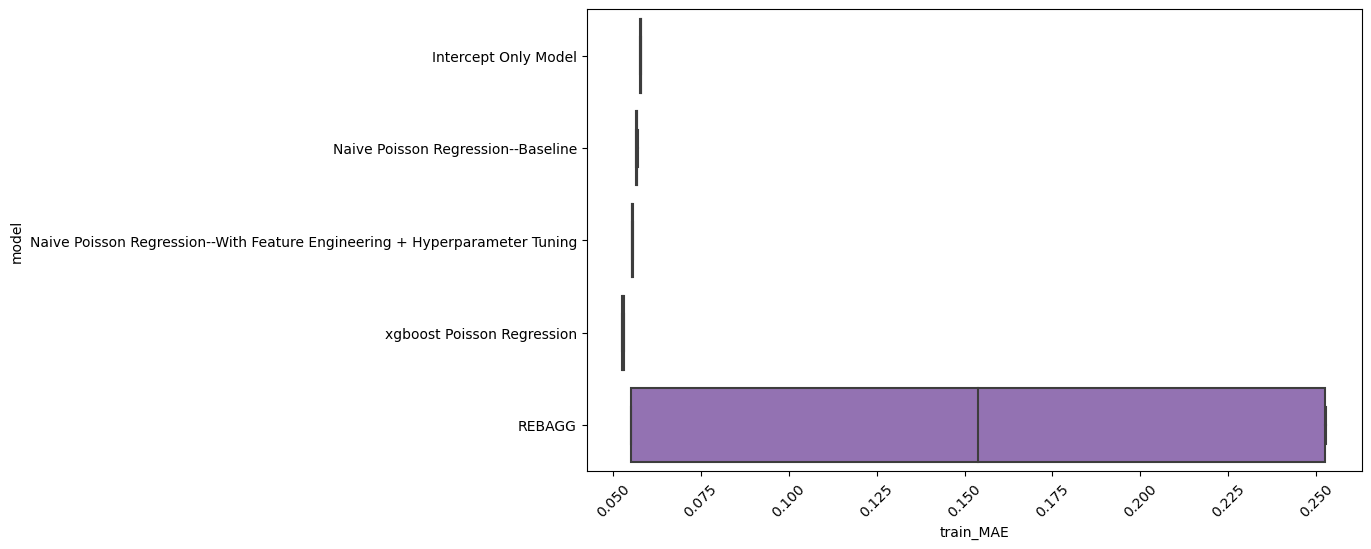

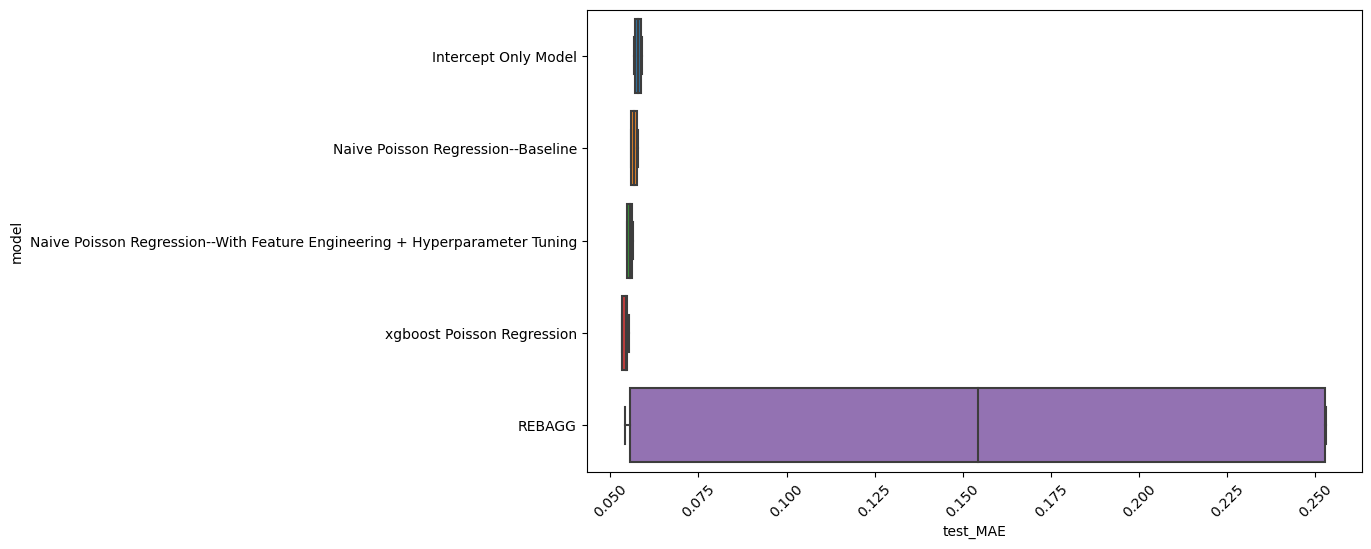

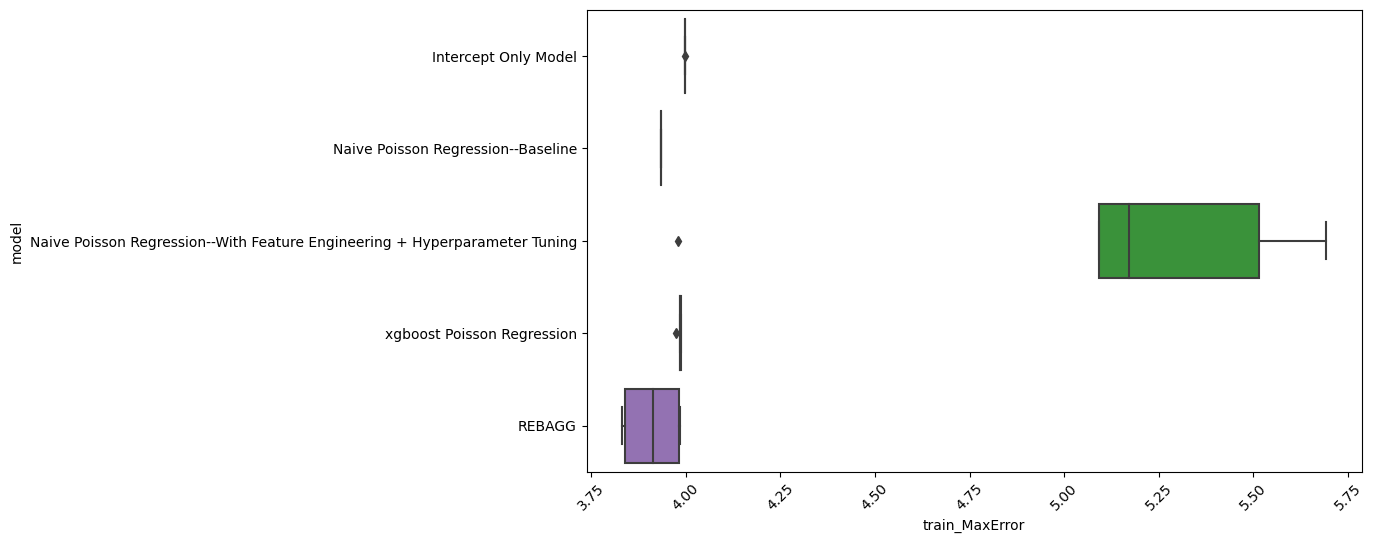

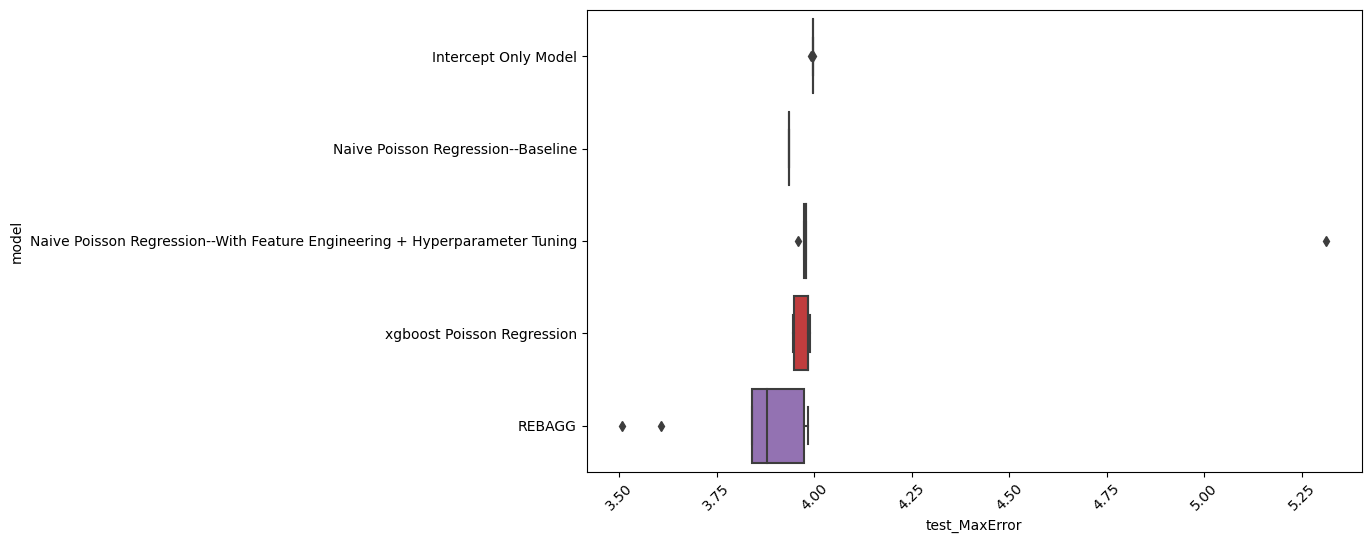

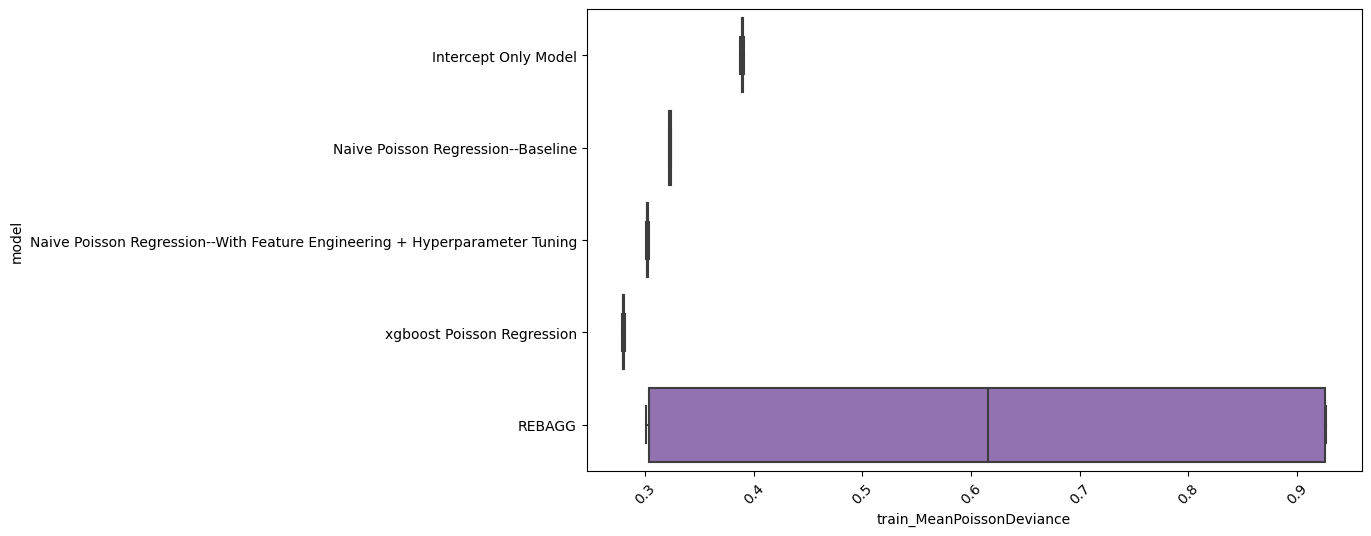

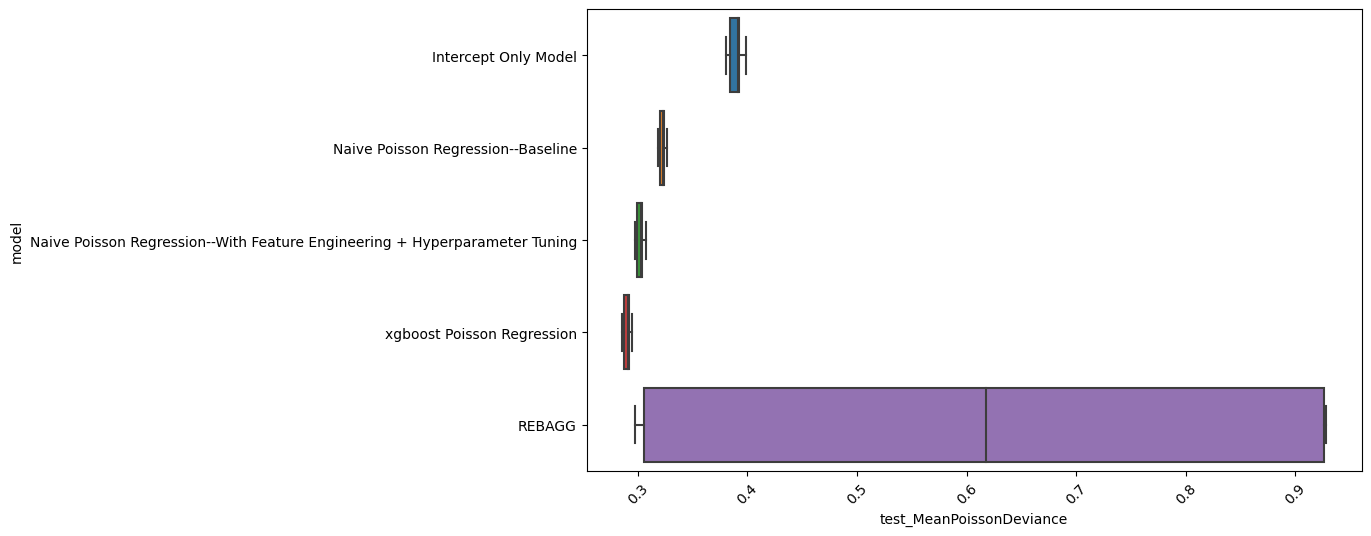

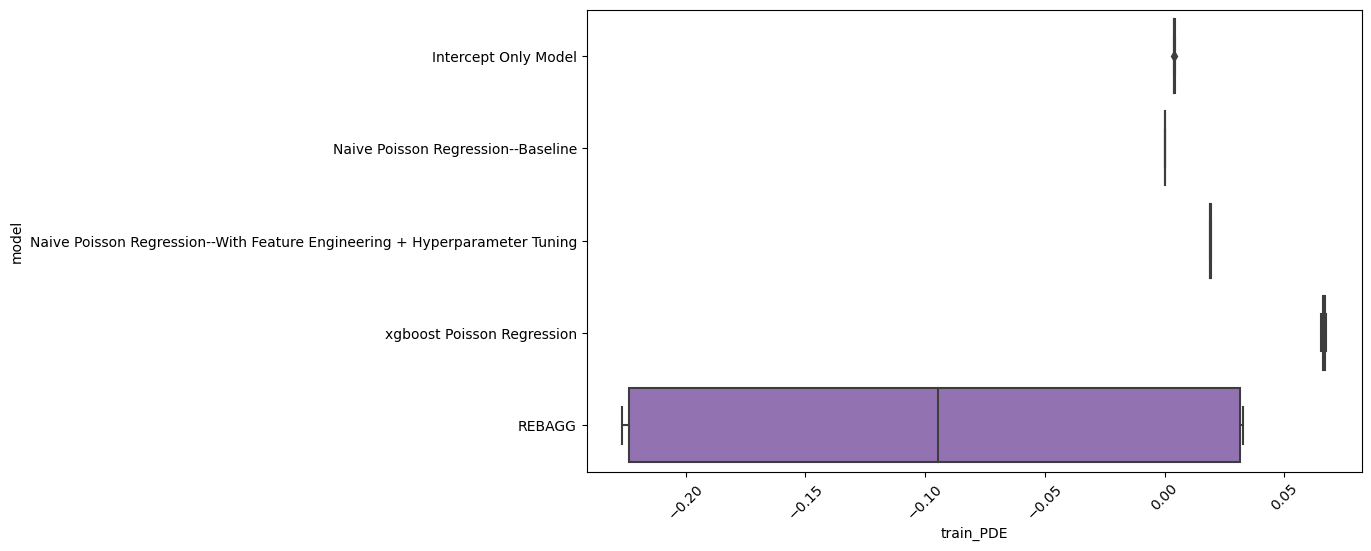

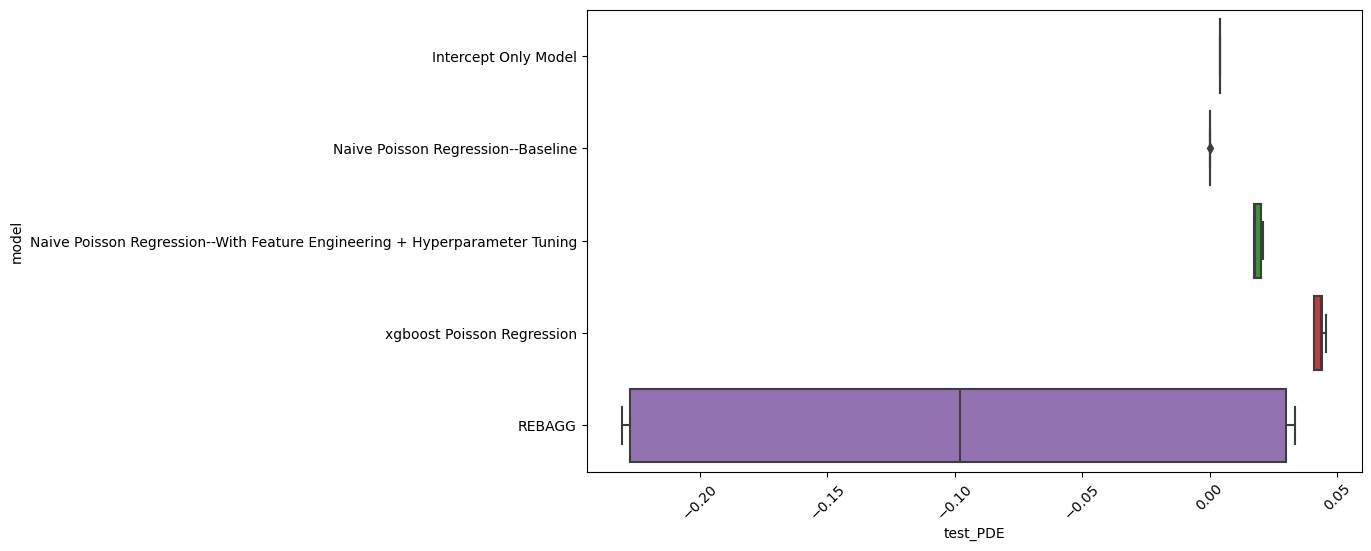

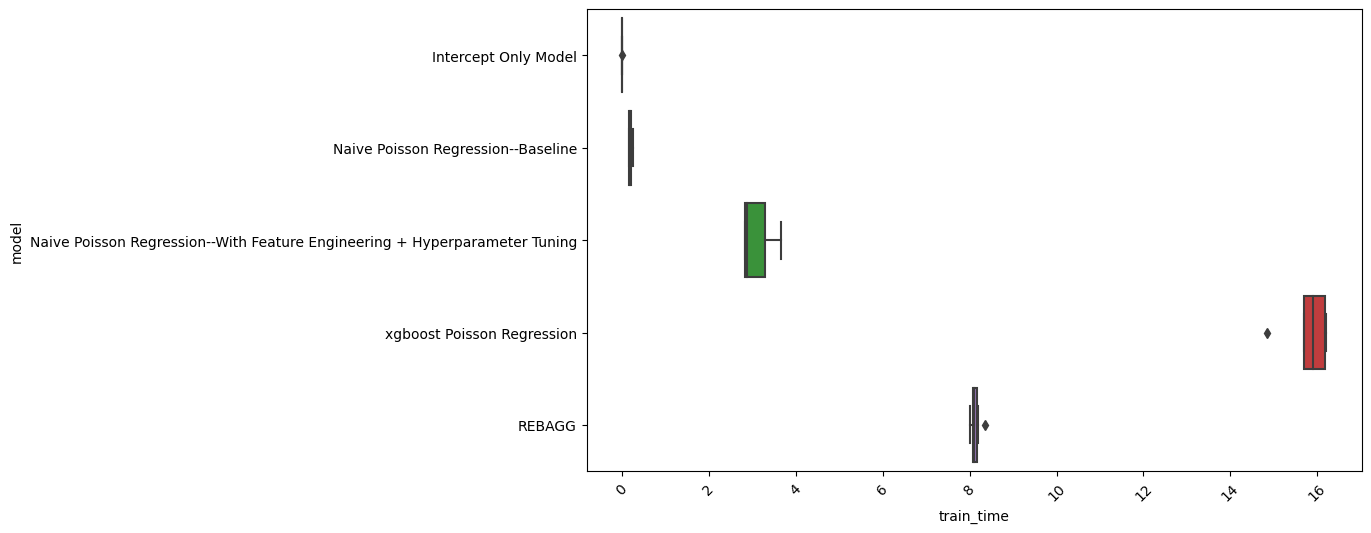

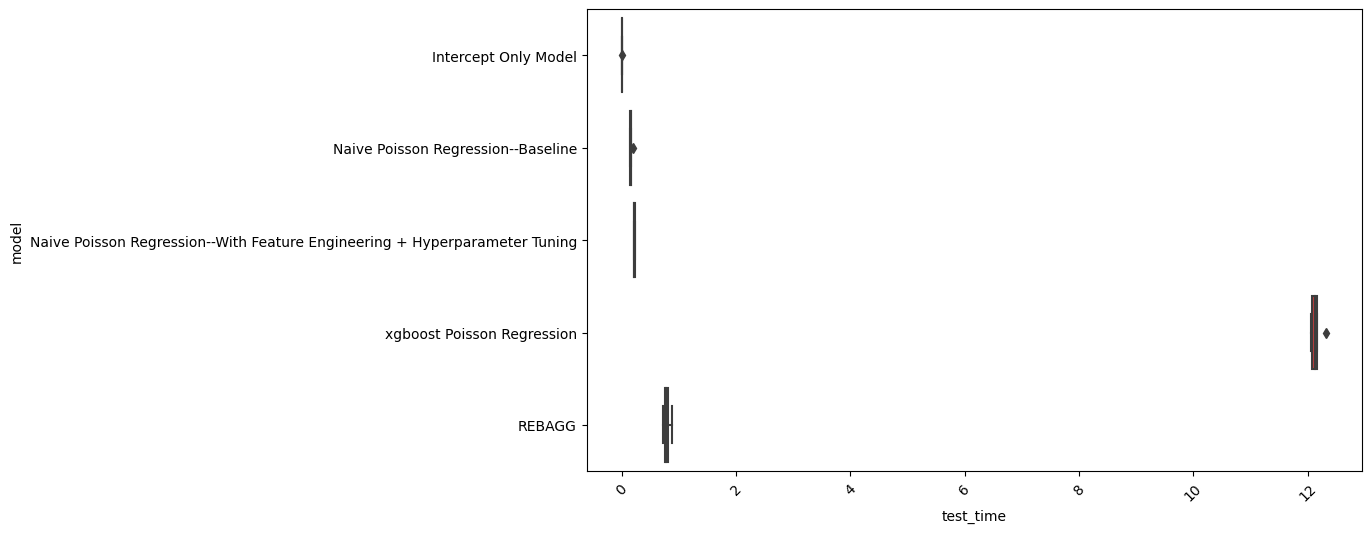

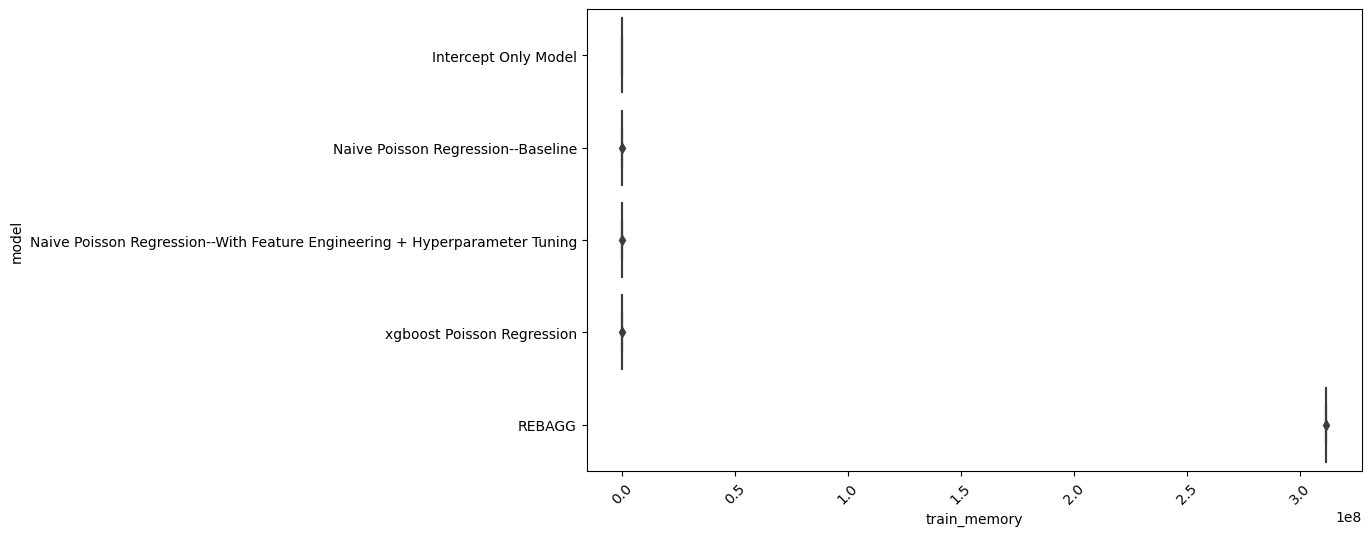

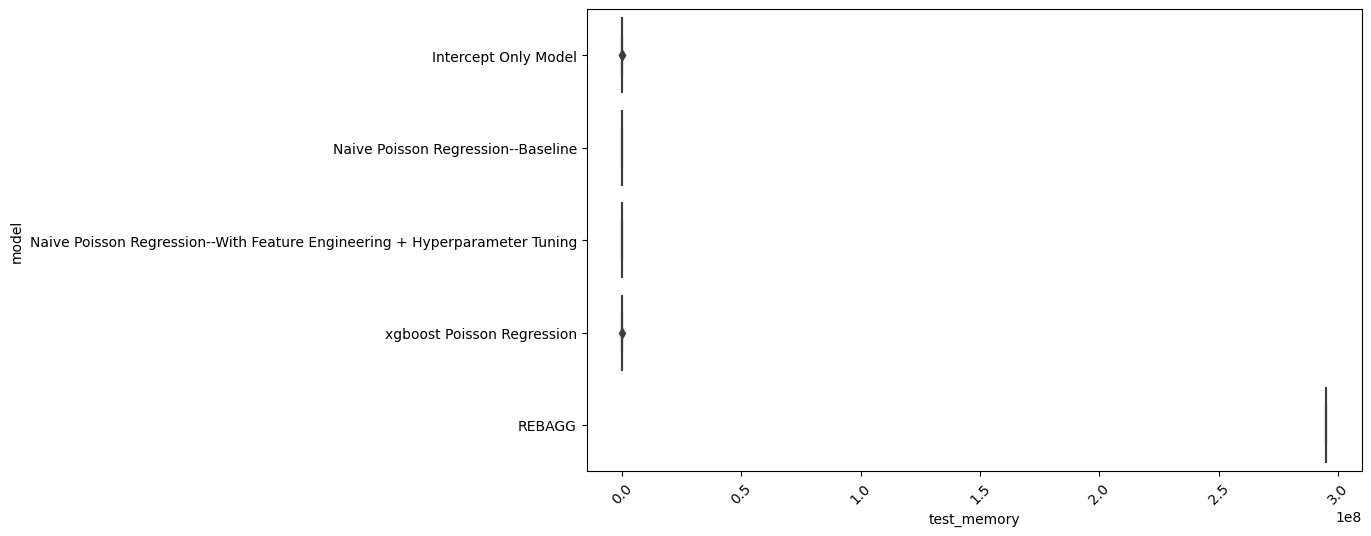

In [13]:
for metric in results[0].keys():
    if metric != "model":
        plt.figure(figsize=(10, len(results)))
        sns.boxplot(data=df_results, y="model", x=metric)
        plt.xticks(rotation=45)
        plt.show()
